# Traveling Salesman Problem

## Filepaths

In [61]:
# Set filepath for CSV with cost / distance data
cost_filepath = 'Orders_Data_15.csv' # file with distances between each node
coord_filepath = 'XYcoord_15.csv' # file with x, y coordinates of each node (including the origin)

## Model Initialization

In [62]:
# import Glop linear solver package
from ortools.linear_solver import pywraplp as glp
import csv
import pandas as pd
import time
from datetime import date
import numpy as np
# initialize model object
mymodel = glp.Solver('Traveling Salesman', glp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

## Parameters

In [63]:
# import csv distance matrix as list
with open(cost_filepath, newline='') as f:
    reader = csv.reader(f)
    cost = list(reader)

# remove blanks & converting to integers
for i in range(len(cost)):
    cost[i] = [float(item) for item in cost[i] if item]
cost = [item for item in cost if item]

In [64]:
cost

[[0.0,
  124.016128,
  85.21150157,
  26.0,
  110.4943437,
  111.7586686,
  64.38167441,
  61.00819617,
  65.55150647,
  64.19501538,
  38.60051813,
  83.21658489,
  77.78174593,
  90.02221948,
  116.2841348,
  102.420701,
  82.73451517,
  99.63934966,
  108.240473,
  98.49365462,
  75.07329752],
 [124.016128,
  0.0,
  92.43916919,
  102.2154587,
  56.36488268,
  21.58703314,
  91.78779875,
  83.63013811,
  75.50496672,
  93.77099765,
  87.46427842,
  41.77319715,
  87.00574694,
  74.43117626,
  43.56604182,
  29.83286778,
  45.79301257,
  24.41311123,
  52.0,
  33.06055051,
  49.39635614],
 [85.21150157,
  92.43916919,
  0.0,
  61.13100686,
  43.65775991,
  71.11258679,
  21.02379604,
  100.4041832,
  30.0,
  21.02379604,
  56.61271942,
  75.47184906,
  9.433981132,
  118.0889495,
  56.75385449,
  93.10746479,
  83.23460819,
  75.58438992,
  45.35416188,
  60.01666435,
  61.03277808],
 [26.0,
  102.2154587,
  61.13100686,
  0.0,
  84.52810184,
  87.96590248,
  40.11234224,
  55.946402

In [65]:
# model parameters
N = len(cost) # number of nodes in data frame
M = N + 1000.0 # arbitrarily large number

In [66]:
N

21

## Decision Variables

In [67]:
use_arc = [list(range(1 + N * i, 1 + N * (i+1))) for i in range(N)] 
for i in range(N):
    for j in range(N):
        use_arc[i][j] = mymodel.IntVar(0, 1, str(i) + "." + str(j))
len(use_arc)

21

In [68]:
# create position variable (lambda / u)
pos = list(range(N))
pos[0] = mymodel.IntVar(0, 0, 'p_0')
for i in range(1,N):
    pos[i] = mymodel.IntVar(1, N-1, "p_" + str(i))

## Objective

In [69]:
# create objective function
shortest_route = mymodel.Objective()
shortest_route.SetMinimization()
for i in range(N):
    for j in range(N):
        shortest_route.SetCoefficient(use_arc[i][j], cost[i][j])

## Constraints

### Arc constraints

In [70]:
# Flow Out

Flow_out = list(range(N))

for i in range(N): 
    Flow_out[i] = mymodel.Constraint(1, 1)
    for j in range(N):
        if i != j: Flow_out[i].SetCoefficient(use_arc[i][j], 1)
        
# Flow In

Flow_in = list(range(N))

for i in range(N):
    Flow_in[i] = mymodel.Constraint(1, 1)
    for j in range(N): 
        if i!= j: Flow_in[i].SetCoefficient(use_arc[j][i], 1)

### Position Constraints

In [71]:
MTZ = [list(range(1 + N * i, 1 + N * (i+1))) for i in range(N)] 

for i in range(1,N):
    for j in range(1,N):
        MTZ[i][j] = mymodel.Constraint(-mymodel.infinity(), N-2)
        MTZ[i][j].SetCoefficient(use_arc[i][j], N-1)
        MTZ[i][j].SetCoefficient(pos[i], 1)
        MTZ[i][j].SetCoefficient(pos[j], -1)

### Solve

In [72]:
start_time = time.time()
# Solve the model and print optimal solution
status = mymodel.Solve()                 # solve mymodel and display the solution

print('Solution Status =', status)
print('Number of variables =', mymodel.NumVariables())
print('Number of constraints =', mymodel.NumConstraints())

optimal = shortest_route.Value()
cost_optimal = optimal * 10

# The objective value of the solution.
print('Optimal Value = %.2f' % cost_optimal)

print("Solution Time: %.2f seconds" % (time.time() - start_time))
runtime = round(time.time() - start_time)
today = str(date.today())
# Display optimal solution
#for i in range(N):
#    print('pos[%d] = %d' % (i, pos[i].solution_value()))
#    for j in range(N):
 #       print('From ', i, ' to ', j, ': ', use_arc[i][j].solution_value(), sep = '')

Solution Status = 0
Number of variables = 462
Number of constraints = 442
Optimal Value = 4617.15
Solution Time: 26.77 seconds


In [73]:
Position = []
From = []
To = []

for i in range(N):
    Position.append(int(pos[i].solution_value() + 1))
    for j in range(N):
        if use_arc[i][j].solution_value() == 1:
            From.append(i)
            To.append(j)
solution = pd.DataFrame(list(zip(Position, From, To)), columns = ['Position', 'From', 'To'])
solution = solution.sort_values('Position').reset_index(drop=True)
solution

,Position,From,To
0,1,0,3
1,2,3,10
2,3,10,8
3,4,8,6
4,5,6,9
5,6,9,12
6,7,12,2
7,8,2,4
8,9,4,18
9,10,18,14


## Plot the Solution

In [74]:
import matplotlib.pyplot as plt
import networkx as nx

In [75]:
# import csv x, y coord matrix as list
with open(coord_filepath, newline='') as f:
    reader = csv.reader(f)
    coord = list(reader)

# remove blanks & converting to integers
for i in range(len(coord)):
    coord[i] = [int(item) for item in coord[i] if item]
coord = [item for item in coord if item]

In [76]:
# Define function to convert list of coordinates to dictionary
def to_dict(my_list):
    dict = {}
    for items in range(len(my_list)):
        dict[items] = my_list[items]
    return dict

In [77]:
coord = to_dict(coord)
coord

{0: [0, 0],
 1: [76, 98],
 2: [85, 6],
 3: [24, 10],
 4: [100, 47],
 5: [81, 77],
 6: [64, 7],
 7: [1, 61],
 8: [61, 24],
 9: [64, 5],
 10: [31, 23],
 11: [45, 70],
 12: [77, 11],
 13: [2, 90],
 14: [99, 61],
 15: [47, 91],
 16: [37, 74],
 17: [62, 78],
 18: [96, 50],
 19: [74, 65],
 20: [50, 56]}

In [78]:
# Define edge list
edge_list = []
for i in range(len(solution)):
    edge_list.append([solution['From'][i], solution['To'][i]])

In [79]:
# Initialize graph object
G = nx.Graph()

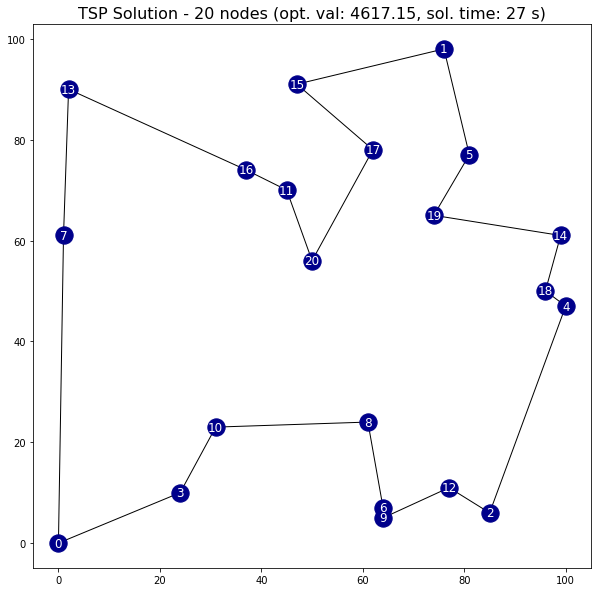

In [80]:
for (u,v) in edge_list:
    G.add_edge(v, u, capacity=1) 
       
fig, ax = plt.subplots(figsize=(10,10))
nx.draw(G, coord, edgelist=edge_list, edge_labels=True, with_labels=True, font_color='w', node_color='darkblue', ax=ax)
#nx.draw_networkx_edges(G, coord, edgelist=droneedgelist, edge_color='darkorange', style='dotted', ax=ax)
limits=plt.axis('on')
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
opt_val = round(cost_optimal, 2)
string = 'TSP Solution - ' + str(N-1) + ' nodes (opt. val: ' + str(opt_val) + ', ' 'sol. time: ' + str(runtime) + ' s)'
ax.set_title(string, fontsize = 16)
plt.show();
saveas = 'TSPoutput_' + str(N-1) +'nodes_' + today +'.png'
fig.savefig(saveas);

### Save solution as CSV

In [81]:
saveas_csv = 'TSPoutput_' + str(N-1) +'nodes_' + today +'.csv'
solution.to_csv(saveas_csv, index=False)